In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.appName('RandomForestKFold').getOrCreate()


path = './data/treino_sinais_vitais_com_label.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

input_cols = ["pSist", "pDiast", "qPa", "pulso", "respiracao"]
output_col = "rotulo"

indexer = StringIndexer(inputCol="rotulo", outputCol="label")
data = indexer.fit(data).transform(data)

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(estimator=rf,
                          evaluator=evaluator,
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

cv_model = crossval.fit(data)

best_model = cv_model.bestModel

predictions = best_model.transform(data)

accuracy = evaluator.evaluate(predictions)

print(f"Precisão do modelo após K-Fold Cross-Validation: {accuracy:.4f}")

predictions.select("features", "label", "prediction").show(10)


Precisão do modelo após K-Fold Cross-Validation: 0.8567
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[13.592433,12.220...|  0.0|       0.0|
|[15.775386,13.586...|  0.0|       0.0|
|[3.649369,1.90480...|  1.0|       0.0|
|[17.264362,13.700...|  0.0|       0.0|
|[12.705183,9.4853...|  1.0|       1.0|
|[7.573969,1.46310...|  2.0|       0.0|
|[11.749524,4.1774...|  0.0|       0.0|
|[9.847899,8.20322...|  1.0|       1.0|
|[18.143625,14.362...|  0.0|       0.0|
|[19.790224,14.473...|  2.0|       2.0|
+--------------------+-----+----------+
only showing top 10 rows



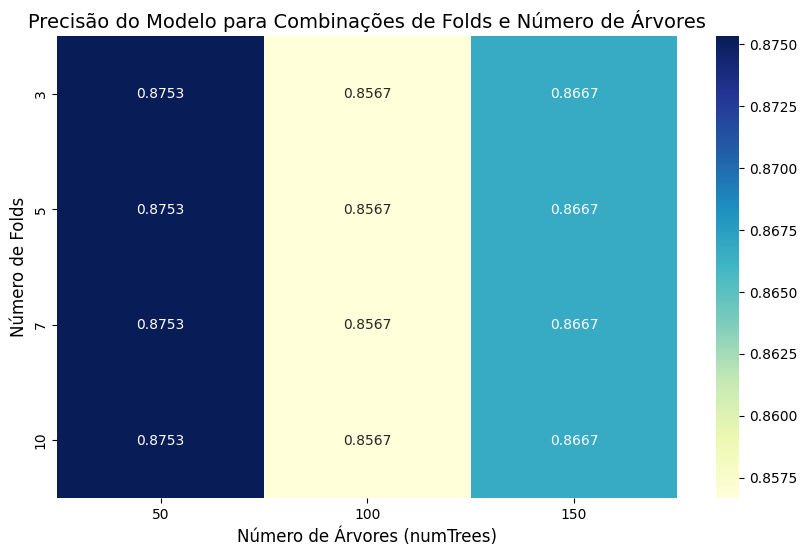

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Inicialização do Spark
spark = SparkSession.builder.appName('RandomForestKFold').getOrCreate()

# Carregar os dados
path = './data/treino_sinais_vitais_com_label.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir as colunas de entrada e saída
input_cols = ["pSist", "pDiast", "qPa", "pulso", "respiracao"]
output_col = "rotulo"

# Transformar a coluna de rótulo em números
indexer = StringIndexer(inputCol="rotulo", outputCol="label")
data = indexer.fit(data).transform(data)

# Criar a coluna de características
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)

# Definir o classificador Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Definir o avaliador
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definir os valores para o número de folds e número de árvores
folds_list = [3, 5, 7, 10]
trees_list = [50, 100, 150]

results = []

# Testar combinações de folds e número de árvores
for k in folds_list:
    for trees in trees_list:
        # Construir o grid de parâmetros com o número de árvores
        paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [trees]).build()

        # Criar o CrossValidator para cada combinação de folds e numTrees
        crossval = CrossValidator(estimator=rf,
                                  evaluator=evaluator,
                                  estimatorParamMaps=paramGrid,
                                  numFolds=k)

        # Treinar o modelo com K-Fold Cross-Validation
        cv_model = crossval.fit(data)

        # Obter as previsões e calcular a precisão
        predictions = cv_model.bestModel.transform(data)
        accuracy = evaluator.evaluate(predictions)

        # Armazenar os resultados
        results.append((k, trees, accuracy))

# Converter os resultados para um DataFrame
results_df = pd.DataFrame(results, columns=['Folds', 'NumTrees', 'Accuracy'])

# Plotar o gráfico
plt.figure(figsize=(10, 6))
results_pivot = results_df.pivot(index='Folds', columns='NumTrees', values='Accuracy')

sns.heatmap(results_pivot, annot=True, cmap="YlGnBu", fmt=".4f")

# Adicionar título e labels
plt.title('Precisão do Modelo para Combinações de Folds e Número de Árvores', fontsize=14)
plt.xlabel('Número de Árvores (numTrees)', fontsize=12)
plt.ylabel('Número de Folds', fontsize=12)

# Exibir o gráfico
plt.show()
